In [0]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
data = pd.read_csv('crypto-markets.csv', parse_dates=['date'],index_col='date')

In [0]:
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [0]:
data = data[data.symbol.isin(['BTC', 'LTC', 'ETH', 'ZEC', 'XRP', 'XMR', 'BCH'])]

In [0]:
data.name.value_counts()

Litecoin        1761
Bitcoin         1761
Ripple          1663
Monero          1372
Ethereum         930
Zcash            481
Bitcoin Cash     214
Name: name, dtype: int64

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8182 entries, 2013-04-28 to 2018-02-21
Data columns (total 12 columns):
slug           8182 non-null object
symbol         8182 non-null object
name           8182 non-null object
ranknow        8182 non-null int64
open           8182 non-null float64
high           8182 non-null float64
low            8182 non-null float64
close          8182 non-null float64
volume         8182 non-null int64
market         8182 non-null int64
close_ratio    8182 non-null float64
spread         8182 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 831.0+ KB


In [0]:
print(data.isnull().sum())

slug           0
symbol         0
name           0
ranknow        0
open           0
high           0
low            0
close          0
volume         0
market         0
close_ratio    0
spread         0
dtype: int64


In [0]:
data.duplicated().sum()

0

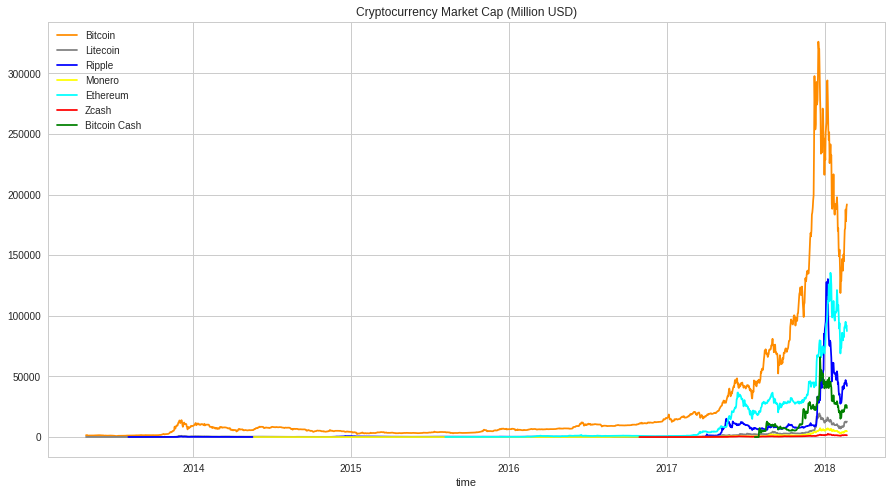

In [0]:
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['market']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['market']/1000000).plot(color='grey', label='Litecoin')
(ripple['market']/1000000).plot(color='blue', label='Ripple')
(monero['market']/1000000).plot(color='yellow', label='Monero')
(ethereum['market']/1000000).plot(color='cyan', label='Ethereum')
(zcash['market']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['market']/1000000).plot(color='green', label='Bitcoin Cash')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Market Cap (Million USD)')
plt.show()

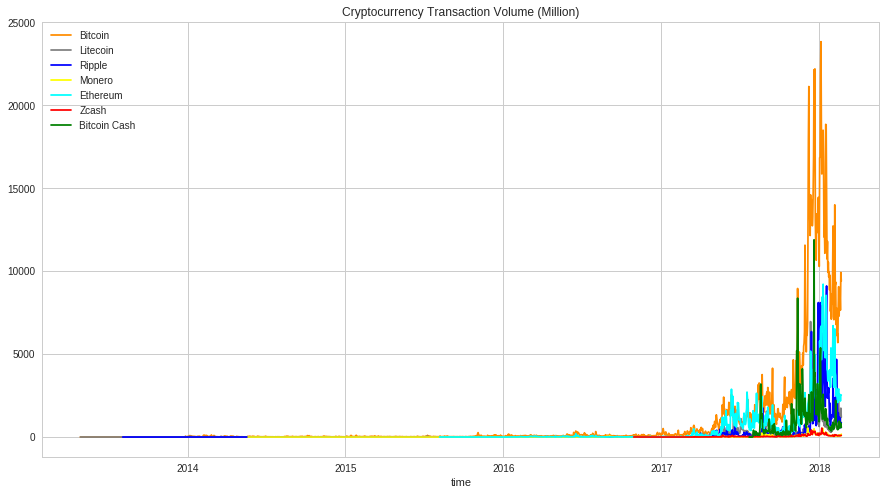

In [0]:
plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['volume']/1000000).plot(color='blue', label='Ripple')
(monero['volume']/1000000).plot(color='yellow', label='Monero')
(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')
(zcash['volume']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['volume']/1000000).plot(color='green', label='Bitcoin Cash')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million)')
plt.show()

2017 was seemingly a breakthrough year for the cryptocurrency

In [0]:
data_m = data['2017-12-01':'2017-12-31']

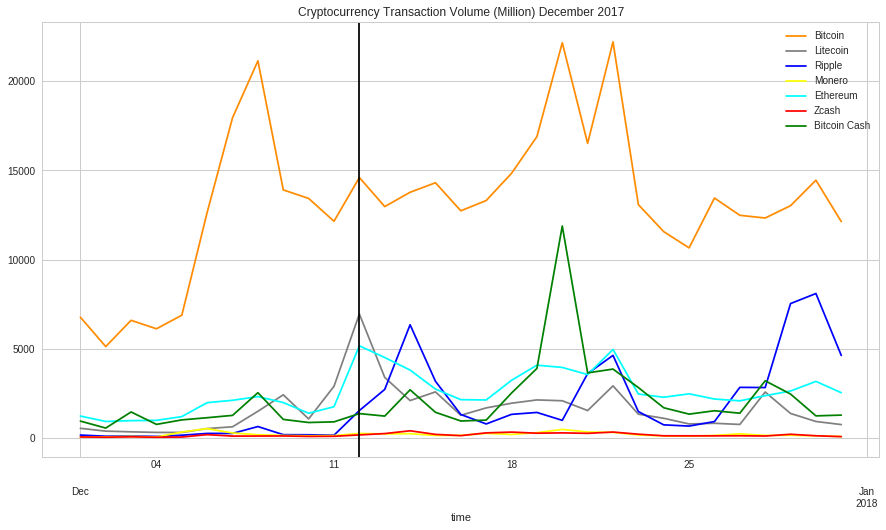

In [0]:
bitcoin = data_m[data_m['symbol']=='BTC']
litecoin = data_m[data_m['symbol']=='LTC']
ripple = data_m[data_m['symbol']=='XRP']
monero = data_m[data_m['symbol']=='XMR']
ethereum = data_m[data_m['symbol']=='ETH']
zcash = data_m[data_m['symbol']=='ZEC']
bitcoin_cash = data_m[data_m['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['volume']/1000000).plot(color='blue', label='Ripple')
(monero['volume']/1000000).plot(color='yellow', label='Monero')
(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')
(zcash['volume']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['volume']/1000000).plot(color='green', label='Bitcoin Cash')
plt.axvline(dt.datetime(2017, 12, 12),color='black')
plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million) December 2017')
plt.show()

focus on 18 and 17

In [0]:
data = data['2017-01-01':]
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775000,15491200000,0.8930,44.38
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222185000,16055100000,0.7221,34.69
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000,16426600000,0.9893,22.48
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344946000,16795400000,0.9592,115.02
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199000,18604000000,0.3668,280.68


In [0]:
data['oc_diff']=data['close']-data['open']
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,oc_diff
date,,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775000,15491200000,0.8930,44.38,34.67
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222185000,16055100000,0.7221,34.69,23.13
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000,16426600000,0.9893,22.48,22.24
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344946000,16795400000,0.9592,115.02,110.33
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199000,18604000000,0.3668,280.68,-143.35


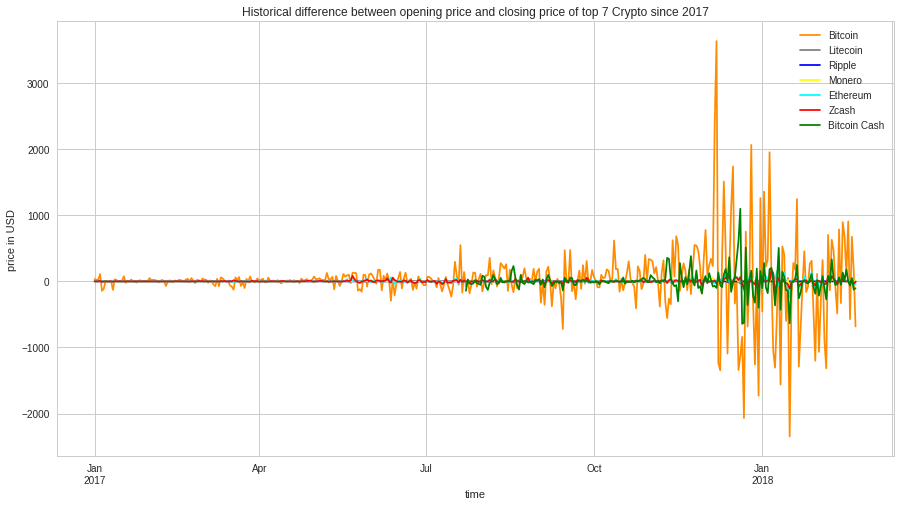

In [0]:
data['oc_diff']=data['close']-data['open']
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['oc_diff']).plot(color='darkorange', label='Bitcoin')
(litecoin['oc_diff']).plot(color='grey', label='Litecoin')
(ripple['oc_diff']).plot(color='blue', label='Ripple')
(monero['oc_diff']).plot(color='yellow', label='Monero')
(ethereum['oc_diff']).plot(color='cyan', label='Ethereum')
(zcash['oc_diff']).plot(color='red', label='Zcash')
(bitcoin_cash['oc_diff']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 7 Crypto since 2017')
plt.legend()
plt.show()

Daily opening price and closing price of BitCoin and BitCoin Cash varies the most

In [0]:
ave_diff={'bitcoin':[(bitcoin['oc_diff']).mean()],
          'litecoin':[(litecoin['oc_diff']).mean()],
          'ripple':[(ripple['oc_diff']).mean()],
          'monero':[(monero['oc_diff']).mean()],
          'ethereum':[(ethereum['oc_diff']).mean()],
          'zcash':[(zcash['oc_diff']).mean()],
          'bitcoin_cash':[(bitcoin_cash['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bitcoin,bitcoin_cash,ethereum,litecoin,monero,ripple,zcash
avg.diff,22.604724,2.66972,1.86199,0.450552,0.638345,0.002482,0.997602


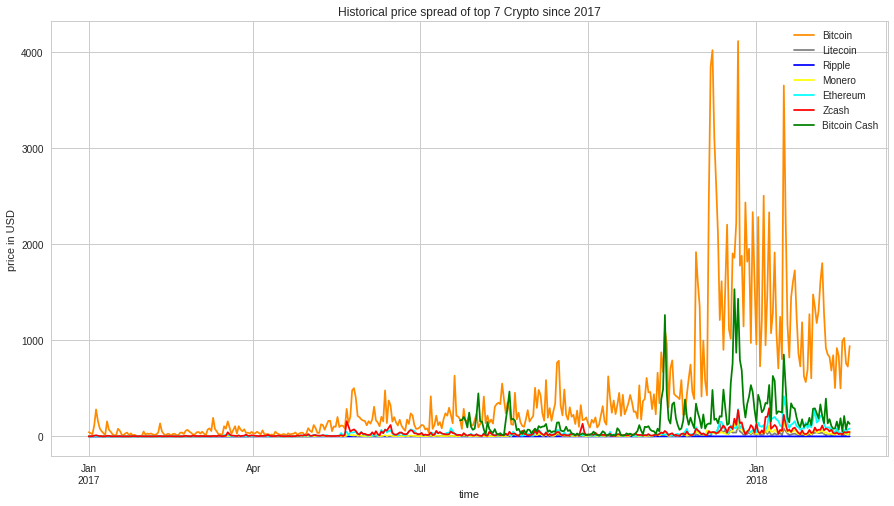

In [0]:
plt.figure(figsize=(15,8))
(bitcoin['spread']).plot(color='darkorange', label='Bitcoin')
(litecoin['spread']).plot(color='grey', label='Litecoin')
(ripple['spread']).plot(color='blue', label='Ripple')
(monero['spread']).plot(color='yellow', label='Monero')
(ethereum['spread']).plot(color='cyan', label='Ethereum')
(zcash['spread']).plot(color='red', label='Zcash')
(bitcoin_cash['spread']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical price spread of top 7 Crypto since 2017')
plt.legend()
plt.show()

By plotting the spread (difference) between daily highest and lowest price, we found that:

**Daily price of BitCoin and BitCoin Cash varies the most           
Zcash and Ethereum varies slightly                
The rest of the cryptocurrencies that we selected tends to be fairly stable**

In [0]:
ave_spread={'bitcoin':[(bitcoin['spread']).mean()],
          'litecoin':[(litecoin['spread']).mean()],
          'ripple':[(ripple['spread']).mean()],
          'monero':[(monero['spread']).mean()],
          'ethereum':[(ethereum['spread']).mean()],
          'zcash':[(zcash['spread']).mean()],
          'bitcoin_cash':[(bitcoin_cash['spread']).mean()]}
pd.DataFrame(ave_spread, index=['avg.spread'])

,bitcoin,bitcoin_cash,ethereum,litecoin,monero,ripple,zcash
avg.spread,440.968441,184.490654,33.442902,8.522134,13.670096,0.061031,29.354652


In [0]:
# calculate 5-day moving averages
btc = bitcoin[['close']]
btc.columns = ['BTC']
btc_ma=btc.rolling(window=5).mean()

ltc = litecoin[['close']]
ltc.columns = ['LTC']
ltc_ma=ltc.rolling(window=5).mean()

xrp = ripple[['close']]
xrp.columns = ['XRP']
xrp_ma=xrp.rolling(window=5).mean()

xmr = monero[['close']]
xmr.columns = ['XMR']
xmr_ma=xmr.rolling(window=5).mean()

eth = ethereum[['close']]
eth.columns = ['ETH']
eth_ma=eth.rolling(window=5).mean()

zec = zcash[['close']]
zec.columns = ['ZEC']
zec_ma=zec.rolling(window=5).mean()

bch = bitcoin_cash[['close']]
bch.columns = ['BCH']
bch_ma=bch.rolling(window=5).mean()

# create matrix of close price only for later use
close = pd.concat([btc,ltc,xrp,xmr,eth,zec,bch], axis=1)
close_ma = pd.concat([btc_ma,ltc_ma,xrp_ma,xmr_ma,eth_ma,zec_ma,bch_ma], axis=1)
close_ma.tail()

,BTC,LTC,XRP,XMR,ETH,ZEC,BCH
date,,,,,,,
2018-02-17,9921.188,211.586,1.132,287.350,924.826,478.006,1414.730
2018-02-18,10311.886,222.824,1.150,300.436,940.558,478.784,1465.826
2018-02-19,10658.020,224.764,1.150,308.402,944.620,476.620,1500.326
2018-02-20,10905.480,226.248,1.138,308.632,936.298,466.984,1508.910
2018-02-21,10996.780,222.894,1.114,313.858,917.450,457.640,1460.162


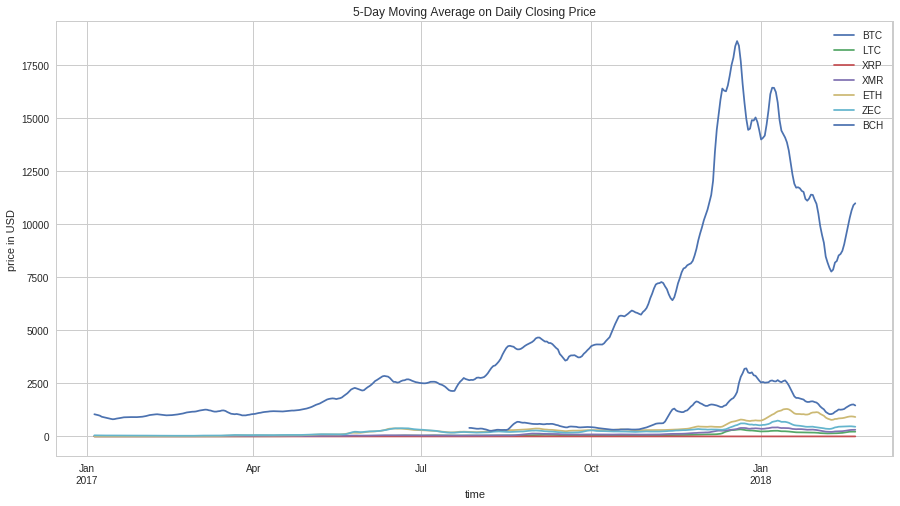

In [0]:
# plot moving average for closing price for cryptocurrencies
close_ma.plot(figsize=(15,8))
plt.title('5-Day Moving Average on Daily Closing Price')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.show()

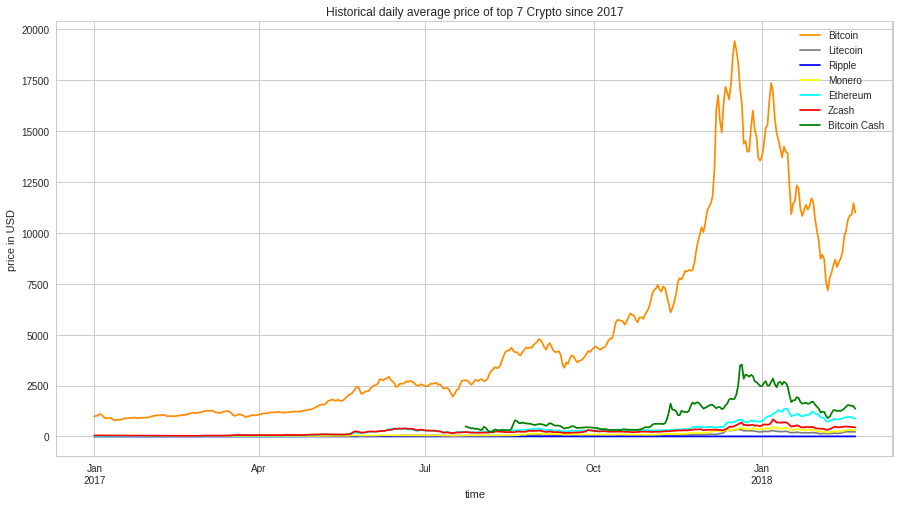

In [0]:
# calculate daily average price
data['daily_avg'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['daily_avg']).plot(color='darkorange', label='Bitcoin')
(litecoin['daily_avg']).plot(color='grey', label='Litecoin')
(ripple['daily_avg']).plot(color='blue', label='Ripple')
(monero['daily_avg']).plot(color='yellow', label='Monero')
(ethereum['daily_avg']).plot(color='cyan', label='Ethereum')
(zcash['daily_avg']).plot(color='red', label='Zcash')
(bitcoin_cash['daily_avg']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical daily average price of top 7 Crypto since 2017')
plt.legend()
plt.show()

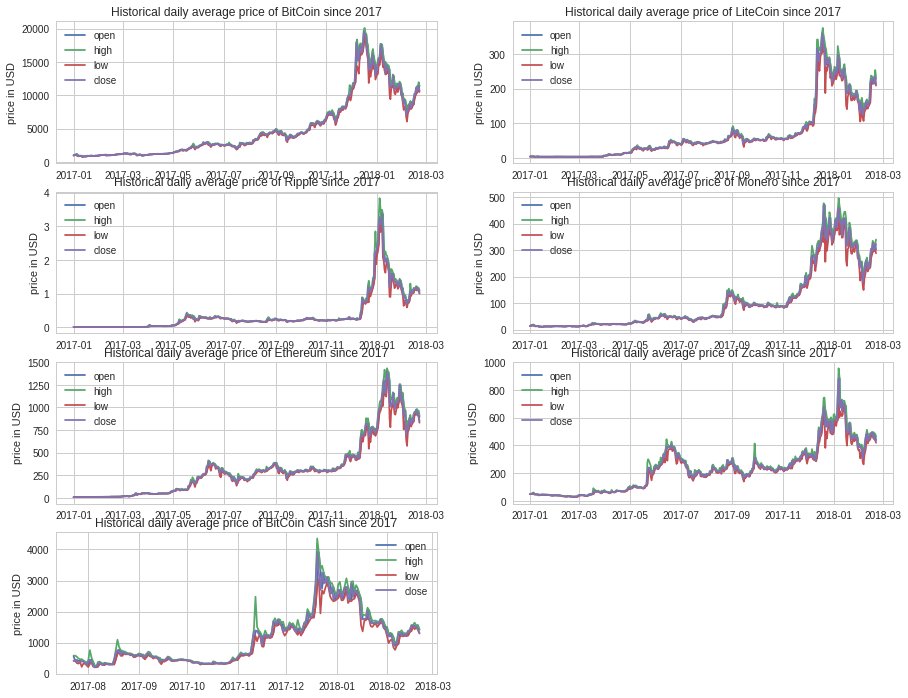

In [0]:
plt.figure(figsize=(15, 12))
plt.subplot(4,2,1)
plt.plot(bitcoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,2)
plt.plot(litecoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of LiteCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,3)
plt.plot(ripple[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ripple since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,4)
plt.plot(monero[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Monero since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,5)
plt.plot(ethereum[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ethereum since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,6)
plt.plot(zcash[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Zcash since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,7)
plt.plot(bitcoin_cash[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin Cash since 2017')
plt.legend(['open','high','low','close'])

plt.show()

Check Pearson correlation coefficient to prove if BitCoin price influences price of other cryptocurrencies

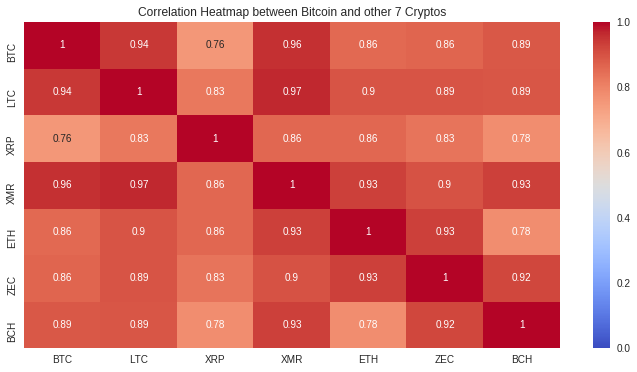

In [0]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other 7 Cryptos')
plt.show()

Based on the heatmap as well as some of the previous plots, we can say that Bitcoin price does have strong impact to other cryptocurrencies.

As the transaction volume of BitCoin increased, the volume of the other cryptocurrencies also increased.

As the price of BitCoin increased, the price of the other cryptocurrencies also increased.

It seems like BitCoin is leading the market changes.

Prices of other cryptocurrency have strong positive correaltion with price of BitCoin

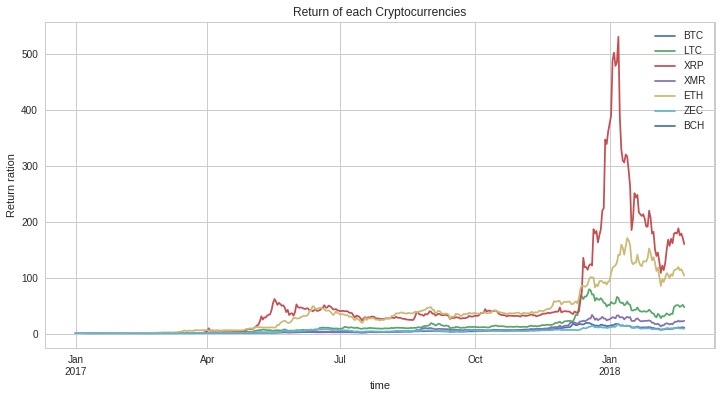

In [0]:
#return ratio = current value of the cryptocurrency / initial value of the cryptocurrency

returns = close.apply(lambda x: x/x[0])
returns.plot(figsize=(12,6))
plt.ylabel('Return ration')
plt.xlabel('time')
plt.title('Return of each Cryptocurrencies')
plt.show()

It looks like since 2017, Ripple (XRP) and Ethereum (ETH) have the highest return ratio, while the rest of cryptocurrencies remains fairly stable.

Investing in Ripple and Ethereum might get better returns but since 2018, the trend is downward.

Investing in popular cryptocurrencies like BitCoin and LiteCoin might still worth a try since their price is fairly stable and there seems to be an upward trend.